In [1]:
import math
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [97]:
def generate_sample_f_star(N, t="uniform", densities=None, selected_densities=None, s=5, cvx_rand=False, dist_rect=None):
    # Generate a sample of n points in [0,1]
    # t can be uniform, convex, rect, in the case of convex, a convex combination of elements of gaussian 
    # densities will be taken with a sparsity s
    if t=="uniform":
        X_ = np.random.uniform(low=0, high=1, size=N)
        return X_
    if t=="convex":
        if densities == None:
            raise ValueError("Densities were not given")
        def generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters):
            X = np.zeros(N)
            t=0
            #We generate the sample according to the selected densities and the weights
            for i in range(s):
                X_d = densities[selected_densities[i]].rvs(sample_repartition_among_clusters[i])
                #We check if X_d is an array or a single element
                X_d = X_d if type(X_d)==np.ndarray else np.array([X_d])
                X[t:t+X_d.shape[0]] = X_d
                t+=X_d.shape[0]
            np.random.shuffle(X)
            return X
        # We select randomly s elements in densities, then we have two possibilities depending on cvx_rand:
        # false: equal weight for each densities, w=1/s
        # true: random weights
        if selected_densities == None:
            selected_densities = np.random.choice(len(densities), s, replace=False)
        s = len(selected_densities)
        print "selected densities: ", sorted(selected_densities)
        if cvx_rand:
            #We generate the weights
            weights = np.random.randint(N*100, size=(1, s))[0]
            weights = 1.*weights/weights.sum()
            sample_repartition_among_clusters = np.random.multinomial(N, weights, size=1)[0]
            return generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters)
        else:
            a = round(N/s)*np.ones(s)
            #We adjust the size to the last element
            a[-1]= a[-1]-(a.sum()-N)
            sample_repartition_among_clusters = a.astype(int)
            return generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters)
    if t=="rect":
        def prob_estim(x, dist_rect):
            for intval in sorted(dist_rect.keys()):
                if x <= intval[1]:
                    return dist_rect[intval]
        X_ = np.linspace(0,1,10*N)
        proba = np.array([prob_estim(x, dist_rect) for x in X_])
        proba = proba/proba.sum()
        return np.random.choice(X_, size=N, p=proba)
                
            

        
        
        
        

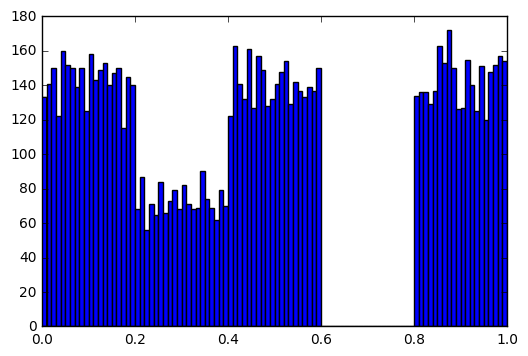

In [115]:
from scipy.stats import multivariate_normal
import numpy as np
nodes = np.linspace(0, 1, 50)
var = 10**(-4)
densities = [multivariate_normal(m, var) for m in nodes]
dist_rect = {
    (0,1./5) : 10./7,
    (1./5,2./5) : 5./7,
    (2./5,3./5) : 10./7,
    (3./5,4./5) : 0,
    (4./5,1) : 10./7
}
X = generate_sample_f_star(10000, t="rect", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect)
#X = generate_sample_f_star(100, t="uniform", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect)
#X = generate_sample_f_star(100, t="convex", densities=densities, cvx_rand=True, s=5, dist_rect=dist_rect)
#X = generate_sample_f_star(100, t="convex", densities=densities, selected_densities=[0,15,20,30,40], cvx_rand=False, s=5, dist_rect=dist_rect)
import matplotlib.pyplot as plt
plt.hist(X, bins=100)  # plt.hist passes it's arguments to np.histogram
plt.show()

In [112]:
from algorithm import WeightEstimator

cl = WeightEstimator(densities_dict=densities, select_threshold=10e-3)
cl.fit(X)
estim_weighted_densities=cl.select_densities()
print estim_weighted_densities

[(1, 0.04427758676180188), (2, 0.026194037352393444), (3, 0.025188462996163917), (4, 0.026854124836611093), (5, 0.03292358272246875), (6, 0.02333754194449237), (7, 0.02980455798546085), (8, 0.035265991264667576), (9, 0.024041103311145444), (10, 0.01525294982011761), (13, 0.013500548508964788), (14, 0.01065883857965496), (15, 0.014451752173505682), (16, 0.017359710890148115), (18, 0.018883715318213156), (19, 0.013258692455761232), (20, 0.039228970305236595), (21, 0.03935456884964278), (22, 0.024823422334437857), (23, 0.02455705301523418), (24, 0.02483025573653531), (25, 0.03459170101658492), (26, 0.02646102542260378), (27, 0.036766772701147137), (28, 0.031731582948997084), (29, 0.023927362310908657), (40, 0.03565331705910168), (41, 0.04978400438081049), (42, 0.013957495669020112), (43, 0.03197548350519769), (44, 0.03686095130019102), (45, 0.018864954823827582), (46, 0.02640426572389709), (47, 0.022692014621964123), (48, 0.04605784990966162), (49, 0.01274967458798395)]


# Evaluation